# Unsupervised Learning Techniques
*This is a notebook about Unsupervised Learning Techniques*

## SETUP

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "chapter9_unsupervised"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [73]:
# Extra modules imported during the work
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

from scipy import stats
import urllib.request
from timeit import timeit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.image import imread

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier

## Clustering

In [3]:
# Load the iris dataset
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure classification_vs_clustering_plot


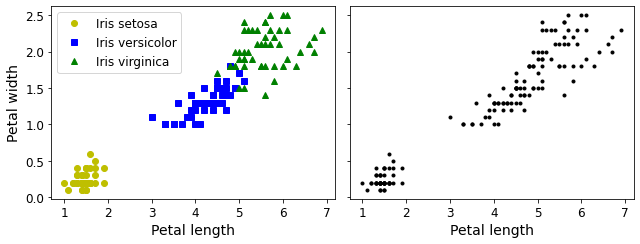

In [4]:
# Plot classification vs clustering
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

In [5]:
# Train a Gaussian mixture model on the iris dataset
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

In [6]:
# Map each cluster to a class
mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{1: 0, 2: 1, 0: 2}

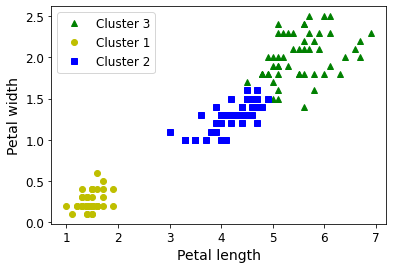

In [7]:
# Plot the clusters from the Gaussian mixture model
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "g^", label="Cluster 3")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "bs", label="Cluster 2")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### K-Means

In [8]:
# Set the blob centers
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [9]:
# Create a blob dataset
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [10]:
# Plot clusters
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


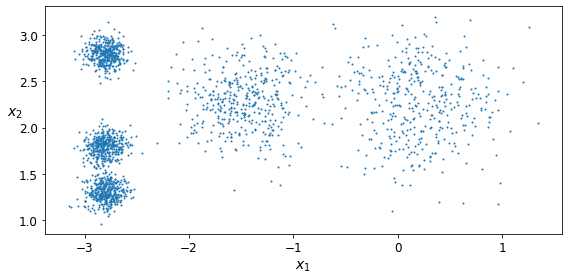

In [11]:
# Plot the unlabeled dataset composed of blobs of instances
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

In [12]:
# Train a K-Means clusterer
k = 5 # the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [13]:
# The instances' label which is the index of the cluster assigned to it by the algorithm
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [14]:
y_pred is kmeans.labels_

True

In [15]:
# The 5 centroids that the algorithm found
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [16]:
# Predict the labels of new instances
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

Saving figure voronoi_plot


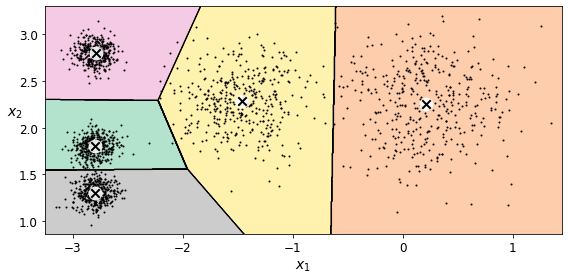

In [17]:
# Plot the model's decision boundaries
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

# plot
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

In [18]:
# Measure the distance between the instance and the centroids
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In [19]:
# Verify using Euclidean distance
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### The K-Means Algorithm

In [20]:
# Train different K-Means clusterers regards the number of iterations
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

Saving figure kmeans_algorithm_plot


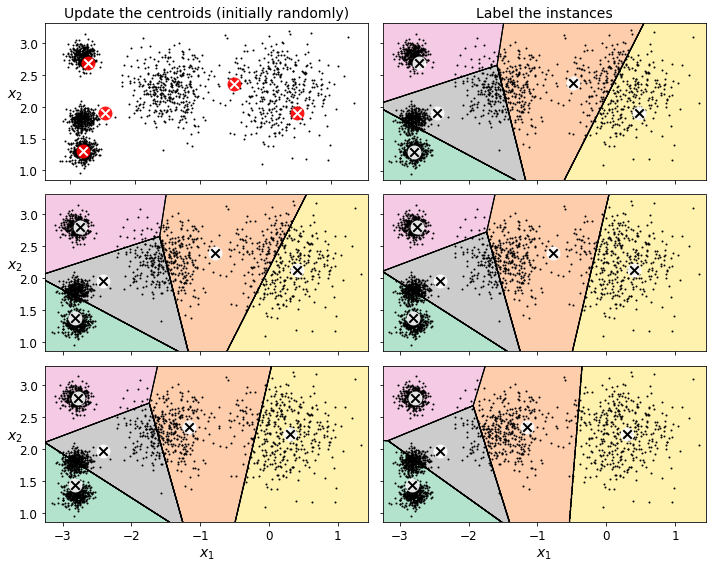

In [21]:
# Plot K-Means Algorithm's process
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

Saving figure kmeans_variability_plot


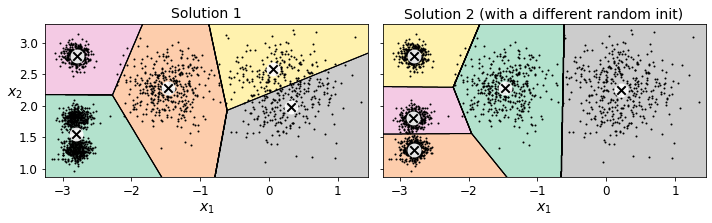

In [22]:
# Plot K-Means variability
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

# plot
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()       

**Remark:** One major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions **(depend on the centroid initialization)**.

### Centroid Initialization Methods

In [23]:
# The centroids known approximately
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]]) # set the init centroids
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.59853725816836

In [24]:
# Run the algorithm multiple times with different random initializations (10 times default)
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10, 
                              algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)
kmeans.inertia_

211.59853725816836

In [25]:
# Measure inertia metric (distance between each instance and its centroid)
kmeans.inertia_

211.59853725816836

In [26]:
# Measure the score of the model (the negative inertia)
kmeans.score(X)

-211.59853725816836

**Remark:** `score()` follows "*great is better*" rule.

### Accelerated K-Means and Mini-batch K-Means

In [28]:
# Train a minibatch K-Means clusterer
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(n_clusters=5, random_state=42)

In [29]:
# Measure the inertia of the minibatch model
minibatch_kmeans.inertia_

211.65239850433198

**Remark:** If the dataset cannot fit in the memory, `memap()` or `partial_fit()` could be used.

In [30]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [31]:
# Write the data to a memap object
X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], random_state=42)

filename = "my_mnist784.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [32]:
# Train a minibatch K-Means clusterer
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

In [32]:
# Setup to load next batch
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

In [33]:
# Pass one mini-batch at a time (partial fit)
np.random.seed(42)

k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  w

In [34]:
# Observe the inertias & training time on the number of clusters k (K-Means vs minibatch K-Means)
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

1/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

2/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

3/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

4/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

5/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

6/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

7/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

8/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

9/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

10/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

11/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

12/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

13/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

14/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

15/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

16/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

17/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

18/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

19/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

20/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

21/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

22/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

23/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

24/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

25/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

26/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

27/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

28/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

29/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

30/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

31/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

32/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

33/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

34/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

35/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

36/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

37/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

38/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

39/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

40/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

41/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

42/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

43/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

44/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

45/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

46/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

47/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

48/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

49/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

50/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

51/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

52/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

53/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

54/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

55/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

56/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

57/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

58/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

59/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

60/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

61/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

62/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

63/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

64/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

65/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

66/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

67/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

68/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

69/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

70/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

71/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

72/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

73/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

74/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

75/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

76/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

77/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

78/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

79/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

80/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

81/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

82/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

83/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

84/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

85/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

86/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

87/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

88/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

89/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

90/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

91/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

92/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

93/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

94/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

95/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

96/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

97/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

98/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

99/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

100/100

E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
E:\IDE\Anaconda\envs\handons_ml\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  w

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

### Finding the Optimal Number of Clusters

Saving figure bad_n_clusters_plot


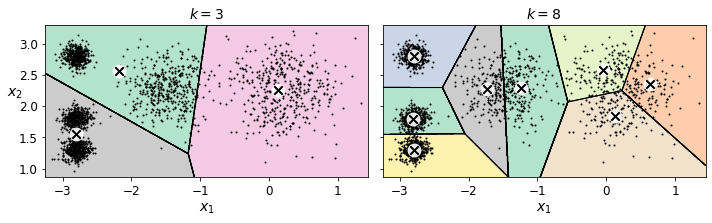

In [35]:
# Train K-Means clusteres with different number of clusters
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

In [36]:
# Measure the inertia of K-Means with 3 clusters
kmeans_k3.inertia_

653.2167190021553

In [37]:
# Measure the inertia of K-Means with 8 clusters
kmeans_k8.inertia_

119.11983416102879

**Remark:** The inertia is not good performance metric when trying to choose `k` since it keeps getting lower as we increase `k`.

#### Elbow Rule (intuitive)

In [38]:
# Observe K-Means with different number of clusters k
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


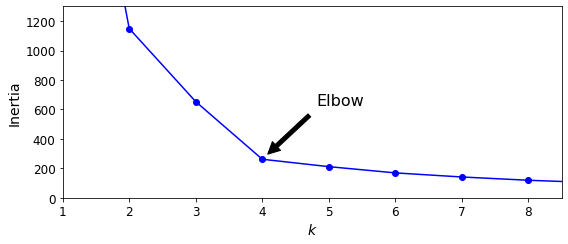

In [39]:
# Plot the inertia on the number of clusters k
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

**Evaluate:** There is an elbow at `k=4`, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half (**Elbow rule**). So `k=4` is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

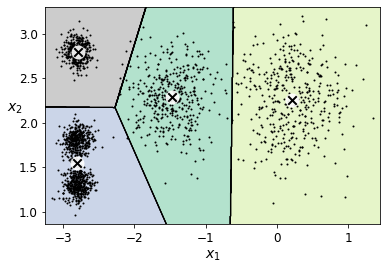

In [40]:
# Plot the decision boundaries of K-Means with k=4
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

#### Silhouette Score (precise)

**Silhouette score**, which is the mean *silhouette coefficient* over all the instances: $\frac{(b-a)}{max(a, b)}$
- $a$ is the mean distance to the other instances in the same cluster (intra distance)
- $b$ is the mean distance to the instances of the next closest cluster

The silhouette coefficient can vary between $-1$ and $+1$: 
- a coefficient close to $+1$ means that the instance is well inside its own cluster and far from other clusters,
- a coefficient close to $0$ means that it is close to a cluster boundary 
- a coefficient close to $-1$ means that the instance may have been assigned to the wrong cluster

In [41]:
silhouette_score(X, kmeans.labels_)

0.6555176425728279

Saving figure silhouette_score_vs_k_plot


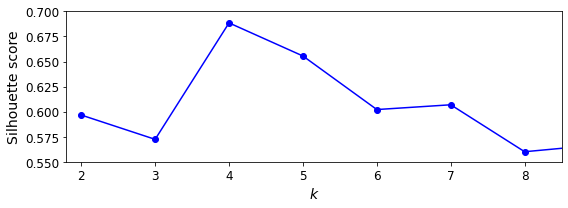

In [42]:
# Compare the silhouette scores for different numbers of clusters
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

**Evaluate:** This visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

#### Silouette Diagram (infomative)

*Plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient*

Saving figure silhouette_analysis_plot


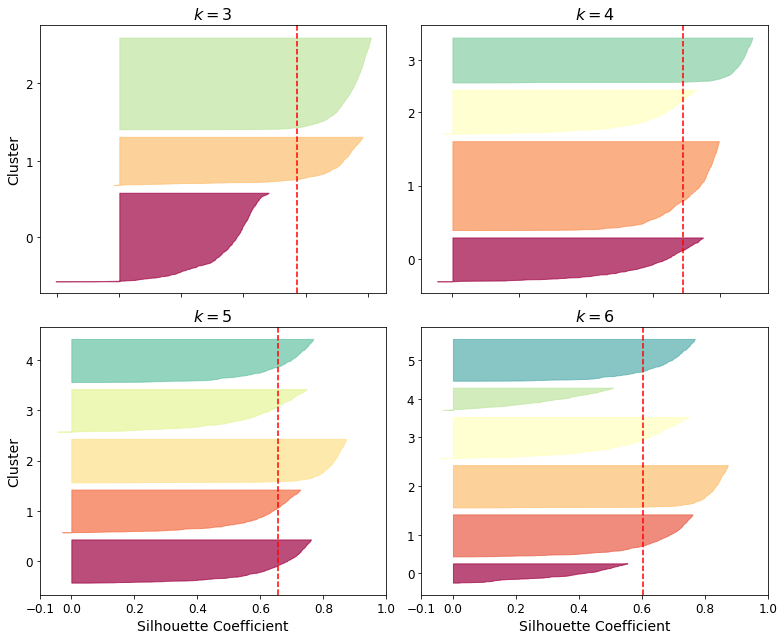

In [43]:
# Plot silouhette analysis: Comparing the silouhette diagrams of various values of k
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

**Evaluate:** The vertical dashed lines represent the silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score, then the cluster is rather bad since this means its instances are much too close to other clusters.
- $k=3$ & $k=6$: Bad clusters
- $k=4$ & $k=5$: Good clusters

=> $k=5$ looks like the best option here, as all clusters are roughly the same size despite its lower silouhette score.

### Limits of K-Means

In [27]:
# Create a blob dataset
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

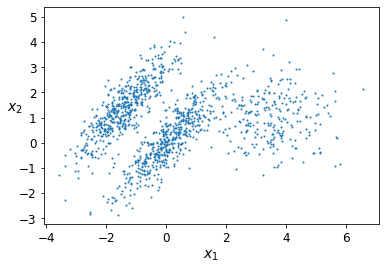

In [28]:
# Plot the data
plot_clusters(X)

In [29]:
# Train K-Means clusterers
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Saving figure bad_kmeans_plot


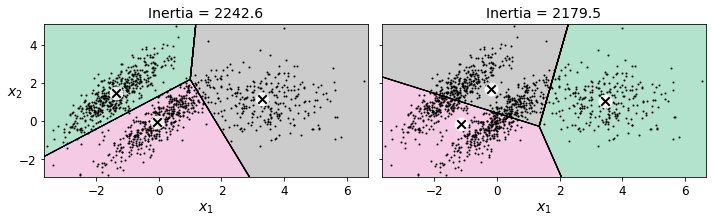

In [30]:
# Plot the clusters from K-Means clusterers
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

**Remark:** K-Means does not behave very well when the clusters have varying sizes, different densities, or non-spherical shapes

### Using clustering for image segmentation

In [31]:
# Download the ladybug image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x25676aeab20>)

In [32]:
# Load the image
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

**Remark:** 
- Height: 533
- Width: 800
- Color channels: 3 (RGB)

In [33]:
# Cluster the color using K-Means
X = image.reshape(-1, 3) # reshape to get the list of RBG
kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_] # for each color, look for the mean color of its cluster
segmented_img = segmented_img.reshape(image.shape) # reshape to the original shape

In [34]:
# K-Means with various numbers of clusters
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


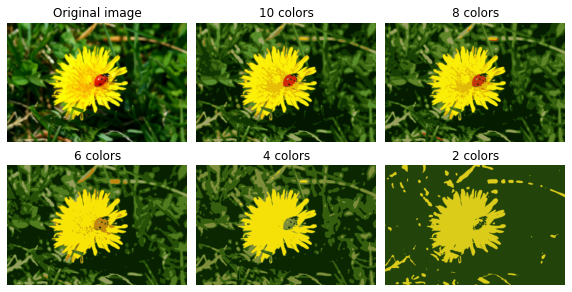

In [35]:
# Plot image segmentation using K-Means with various numbers of color clusters
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### Using Clustering for Preprocessing

In [36]:
# Load the digits dataset
X_digits, y_digits = load_digits(return_X_y=True)

In [37]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [38]:
# Train a Logistic Regression model
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [39]:
# Measure the Logistic Regressor's accuracy
log_reg.score(X_test, y_test)

0.9688888888888889

In [40]:
# Use K-Means as a preprocessing step
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [41]:
# Measure the pipeline's score
pipeline.score(X_test, y_test)

0.9777777777777777

In [42]:
# Using Grid Search to find the optimal number of clusters
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=35; total time=   1.6s
[CV] END ..............................kmeans__n_clusters=36; total time=   2.2s
[CV] END ..............................kmeans__n_clusters=36; total time=   1.9s
[CV] END ..............................kmeans__n_clusters=36; total time=   1.8s
[CV] END ..............................kmeans__n_clusters=37; total time=   2.0s
[CV] END ..............................kmeans__n_clusters=37; total time=   1.9s
[CV] END ..............................kmeans__n_clusters=37; total time=   1.6s
[CV] END ..............................kmeans__n_clusters=38; total time=   2.0s
[CV] END ..............................kmeans__n_clusters=38; total time=   1.9s
[CV] END ..............................kmeans__n_clusters=38; total time=   1.9s
[CV] END ..............................kmeans__n_clusters=39; total time=   1.9s
[CV] END ..............................kmeans__n_clusters=39; total time=   2.0s
[CV] END ...................

[CV] END ..............................kmeans__n_clusters=69; total time=   2.0s
[CV] END ..............................kmeans__n_clusters=70; total time=   2.2s
[CV] END ..............................kmeans__n_clusters=70; total time=   2.5s
[CV] END ..............................kmeans__n_clusters=70; total time=   2.5s
[CV] END ..............................kmeans__n_clusters=71; total time=   2.1s
[CV] END ..............................kmeans__n_clusters=71; total time=   2.4s
[CV] END ..............................kmeans__n_clusters=71; total time=   2.2s
[CV] END ..............................kmeans__n_clusters=72; total time=   2.3s
[CV] END ..............................kmeans__n_clusters=72; total time=   2.6s
[CV] END ..............................kmeans__n_clusters=72; total time=   2.2s
[CV] END ..............................kmeans__n_clusters=73; total time=   2.2s
[CV] END ..............................kmeans__n_clusters=73; total time=   2.3s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [43]:
# The best value for k (the number of cluster)
grid_clf.best_params_

{'kmeans__n_clusters': 69}

In [44]:
# Measure the best model found through Grid Search
grid_clf.score(X_test, y_test)

0.9777777777777777

### Using Clustering for Semi-Supervised Learning

In [45]:
# Train a Logistic Regressor on a sample of 50 labeled instances (random)
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

In [46]:
# Cluster the training set & find the images closest to the centroids
kmeans = KMeans(n_clusters=50, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Saving figure representative_images_diagram


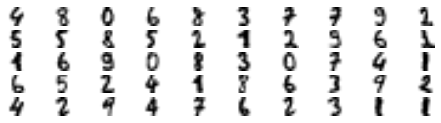

In [48]:
# Plot the representative images
k = 50
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [51]:
# Label the representatives manually
y_representative_digits = y_train[representative_digit_idx]

In [52]:
# Train a Logistic Regressor with 50 labeled instances (representative)
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

**Remark:** It's often costly and painful to label instances, so a good idea is to make them label representative instances rather than just random instances.

In [53]:
# Propagate the labels to all other instances in the same cluster
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k): # k=50
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [54]:
# Train a Logistic Regressor after label propagation
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9333333333333333

**Remark:** Some instances are mislabeled (especially the instances close to the cluster boundaries).

In [56]:
# Propagate the label to only 75% percentile closest to the centroid
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [57]:
# Train a Logistic Regressor on the partially propagated dataset
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9355555555555556

**Evaluate:** With just 50 labeled instances (5 examples per class on avg), the accuracy achieves 93.5% (it seems that the propagated labels are quite accurate).

In [58]:
# Compare the propagated labels with the original ones
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9750747756729811

## DBSCAN

In [60]:
# Load the moon dataset
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [61]:
# Train a DBSCAN model
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [65]:
# Show some labels of all instances assigned by the model
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

**Remark:** Some instances have a cluster index -1, which means they are considered as anomalies.

In [66]:
# Show the indices of the core instances
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [67]:
# Show the number of the core instances
len(dbscan.core_sample_indices_)

808

In [68]:
# Show the core instances
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

In [69]:
# Show the clusters
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [70]:
# Train a DBSCAN model with the distance 0.2
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [71]:
# Setup to plot different DBSCAN clusterings
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


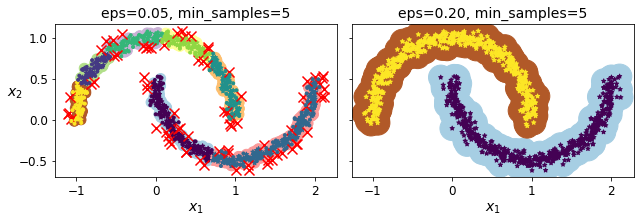

In [72]:
# Plot DBSCAN clustering using two diferrent neighborhood radiuses
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

**Evaluate:** The left plot identified quite a lot of anomalies, which is not good compared to the right one. 

In [74]:
# Train a KNN clf based on DBSCAN
dbscan = dbscan2
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [75]:
# Predict the cluster of the new instances
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [76]:
# Estimate the probability for each cluster
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Saving figure cluster_classification_plot


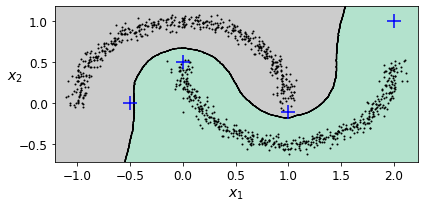

In [79]:
# Plot the cluster classification
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

**Remark:** There is no anomaly in the KNN’s training set, the classifier always chooses a cluster, even when that cluster is far away. *It is fairly straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies.*

In [81]:
# Use KNN to get the distances and the indices of k nearest neighbors
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)